In [1]:
# User variables
SAVE_ELEMENTS = True # True if figures and models shall be saved

In [2]:
# Imports
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import copy
from pm4py.objects.log.util import dataframe_utils
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
import json
import seaborn as sns
from collections import Counter

# Preprocessing
The data is loaded and preprocessed.
Names of events are parsed and unused events are removed.

In [3]:
# removes unused events and parses event names
def process_touchpoint_names(df):
    running_df = df[df['Type'].isin(['state', 'feedback','subject', 'task'])].copy()
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(",", "")
    running_df['concept:name'] = running_df['concept:name'].str.split('version').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('Time used').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('taskDownloaded').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('testCompleted').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.split('itemCompleted').str[0]
    running_df['concept:name'] = running_df['concept:name'].str.strip()

    m = running_df['concept:name'].str.contains("survey:")
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].str.split('survey: ').str[1]

    m = running_df['Type'] == 'state'
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].values
    running_df.loc[~m, 'concept:name'] = running_df['concept:name'][~m].values
    return running_df

# Filters the dataset to only contain traces with length in [lower_bound, upper_bound]
def get_filtered_df(path, lower_bound = 15, upper_bound = 60):
    df = pd.read_csv(path, sep=';', index_col = False)

    log_csv = dataframe_utils.convert_timestamp_columns_in_df(df)
    log_csv = log_csv.sort_values('Timestamp')

    developers_finished_ids = set(log_csv[log_csv['Message'] == "finished"]['Developer ID'].sort_values().values)

    #rename columns to process mining notation
    log_csv.rename(columns={'Developer ID': 'case:DeveloperID', 'Message' : 'concept:name', 'Timestamp':'time:timestamp'}, inplace=True)
    log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], unit='s')

    # process touchpoint names
    developers_df = process_touchpoint_names(log_csv)

    #filter used logs
    developers_df = developers_df.groupby(['case:DeveloperID']).filter(lambda x: len(x) >= lower_bound and len(x) <= upper_bound)

    unsuccesfull = developers_df[~developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    succesfull = developers_df[developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    plt.scatter(range(len(unsuccesfull)), unsuccesfull, c = "r", s = 7)
    plt.scatter(range(len(unsuccesfull),len(unsuccesfull)+(len(succesfull))), succesfull, c = "b", s = 7)
    plt.xlabel("Journeys")
    plt.ylabel("Length")
    plt.show()
    print("Includes #unsuccesfull:", len(unsuccesfull),"and #succesfull", len(succesfull))
    
    print("Histograms")
    sns.displot(data=pd.DataFrame({"Journey Length - Successfull": succesfull}),
            x="Journey Length - Successfull", color='blueviolet', height=3)
    plt.show()
    
    sns.displot(data=pd.DataFrame({"Journey Length - Unsuccessfull": unsuccesfull}),
            x="Journey Length - Unsuccessfull", color='blueviolet', height=3)
    plt.show()
    

    developers_df = developers_df.sort_values(by=['time:timestamp'])

    return developers_df

/tmp/ipykernel_22397/735489142.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_22397/735489142.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


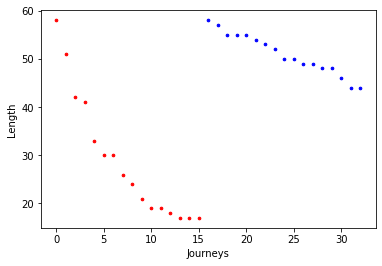

Includes #unsuccesfull: 16 and #succesfull 17
Histograms


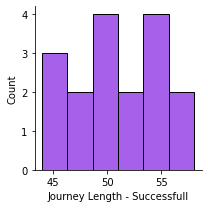

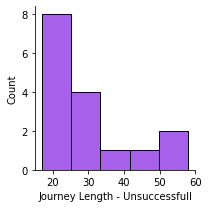

In [4]:
filtered_df = get_filtered_df("20210706-132203-sjm-anonymized.csv")

# Build log
The dataset is flattened to a log structure

In [5]:
success_states = ['finished']
# A log consists of traces, where each trace contains all elements from one developer 
def build_log(df):
    log = []
    running_df = df.copy()
    running_df = running_df.sort_values(by=['time:timestamp'])
    developers_id = set(running_df['case:DeveloperID'].values)
    for dev_id in developers_id:
        current_trace = running_df[running_df['case:DeveloperID'] == dev_id]['concept:name'].values
        # add unique start node "start"
        current_trace = np.insert(current_trace,0,"start")
        # attach final node finPos / finNeg
        if(any(s in current_trace for s in success_states)):
            current_trace = np.append(current_trace,"finPos")
        else:
            current_trace = np.append(current_trace,"finNeg")
        log.append(current_trace)
        
    # alter "logged in: Web page" to determine phase of journey:
    # Phase (1) sign up, (2) solve all programming tasks, and  (3) review and share the skill report with the customer.
    for t in log:
        indices = [i for i, x in enumerate(t) if x == "Logged in: Web page"]
        for i in indices:
            t[i] = "Logged in: Web page - Sign up"
            result = np.where(t == "Task event:")
            if "Task event:" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Task"
            result = np.where(t == "waitingForResultApproval")
            if "waitingForResultApproval" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Approval"
                
    # add task number
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_task:
            count_indices = [j for j in indices_feedback if j < i] # uses feedback to increase task counter after giving feedback
            t[i] += " "+str(len(count_indices))
    # add feedback number        
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_feedback:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    
    return log

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

In [6]:
log = build_log(filtered_df)

# Create DFG

In [7]:
# Builds the directly follows graph according to the log
# Removes all edges which are traversed less than "threshold" times
def build_dfg(log, threshold):
    states = list(set([item for sublist in log for item in sublist])) # flatten list

    edges = []
    edge_counter = {}
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
    
    g = nx.DiGraph()
    g.add_nodes_from(states)
    max_val = max(edge_counter.values())
    for e in edges:
        g.add_edge(e[0], e[1], edge_weight = edge_counter[e]/max_val) # adds "thickness" element

    # remove all simple loops & rarely traversed edges
    to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            to_remove.append(e)

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    # remove isolated nodes
    g.remove_nodes_from(list(nx.isolates(g)))
    
    return g

def draw_dfg(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)

In [8]:
g = build_dfg(log,3)

# Burnd-Down Chart of Developers

In [9]:
# Draw the burn down chart of developers leaving the journey per touchpoint, Figure 6
def draw_burn_down(g,s, t, log):
    g_copy = copy.deepcopy(g)
    edge_counter = {}
    node_counter = {}
    
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edge_counter:
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
            
    for trace in log:
        for pos in set(trace):
            if pos in node_counter:
                node_counter[pos] = node_counter[pos]+1
            else:
                node_counter[pos] = 1
            continue

    for e in edge_counter:
        if e[1] == "finNeg":
            print(e, edge_counter[e])
    
    x = [100,81, 72, 64, 52]
    y = ["start", "T10", "T12", "T14", "T25"]
    x2 = [0,18,9,9,12]
    y2 = ["start", "T10", "T12", "T14", "T25"]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(y,x, 'o-')
    ax.bar(y2, x2, color="r")
    plt.ylabel("Developers (in %)", fontsize=18)
    plt.xlabel("Events", fontsize=18)
    plt.show()

('Task event: 1', 'finNeg') 6
('Task event: 2', 'finNeg') 3
('waitingForActivityReport', 'finNeg') 4
('Task event: 3', 'finNeg') 3


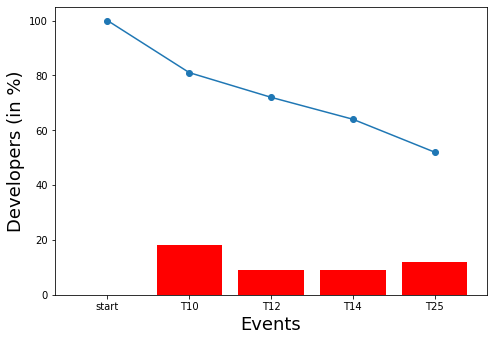

In [10]:
draw_burn_down(g, "start", "finNeg", log)

# DFG to Customer Journey Game

In [11]:
# load actors from given file
# The file maps events to actors in xml format
# Every unspecified event is controllable
with open('activities.xml') as f:
    data = f.read()
actors = json.loads(data)

In [12]:
# stores actors in graph
def extend_graph_with_actors(g, actors):  
    for node in g.nodes:
        if node not in actors:
            g.nodes[node]['controllable'] = True
        else:
            g.nodes[node]['controllable'] = actors[node] == "company"

In [13]:
extend_graph_with_actors(g,actors)

In [14]:
# Helper functions to compute weights for edges

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

def weight(trace):
    return 1 if any("finished" in pos for pos in trace) else -1

def majority(s,t,log):
    maj = 0
    for trace in log:
        if isInTrace(s,t,trace):
            maj += weight(trace)
    return 1 if maj == 0 else int(maj/abs(maj))

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log):
    distr = {1.0: 0 , -1.0 : 0}
    for trace in log:
        if isInTrace(s,t,trace):
            w = weight(trace)
            distr[w] += 1
    return distr[1], distr[-1]

def compute_edge_cost(log):
    weights = [1 if "finished" in i else -1 for i in log]
    edge_cost = {}
    for s in g.nodes:
        for t in g[s]:
            p1, p2 = distribution(s,t,log)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            w = majority(s,t,log)
            scaling = 10
            edge_cost[(s,t)] = (((1-entropy(wp1,wp2)) * w) -0.1 )*20
    print("Edge cost was computed")
    return edge_cost

In [15]:
edge_cost = compute_edge_cost(log)

Edge cost was computed


In [16]:
# annotates graph with cost-labels
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

# Colors graph labels green/red depending of the weight is positive or negative
def color_graph(g):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > 0:
            g[e[0]][e[1]]['color'] ="darkgreen"
        if g[e[0]][e[1]]['label'] < 0:
            g[e[0]][e[1]]['color'] ="red"
    
    return g

# Plots clustered DFG, Figure 5
def draw_dfg_clustered(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = 70
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"

    for n in A.nodes():
        n.attr['fontsize'] = 80
    onboarding = ["T"+str(i) for i in range(0,6)]
    A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 60, fontcolor = "orange")
    task = ["T"+str(i) for i in range(6,21)]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 60, fontcolor = "blue")
    evaluation = ["T"+str(i) for i in range(21,27)]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 60, fontcolor = "purple")
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
        
# Introduced naming for readable function
naming = {
    "registered" : "T0",
    "activated": "T1",
    "Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T4",
    "readyToStart" : "T5",
    "Task event: loggedIn" : "T6",
    "started" : "T7",
    "Task event: 0": "T8",
    "Give feedback 0" : "T9",
    "Task event: 1": "T10",
    "Give feedback 1" : "T11",
    "Task event: 2": "T12",
    "Give feedback 2" : "T13",
    "Task event: 3": "T14",
    "Give feedback 3" : "T15",
    "Task event: 4": "T16",
    "Give feedback 4" : "T17",
    "Task event: 5": "T18",
    "waitingForManualScores" : "T19",
    "Logged in: Web page - Task" : "T20",
    "waitingForScores" : "T21",
    "waitingForResultApproval" : "T22",
    "waitingForSubjectAcceptance" : "T23",
    "subjectAcceptanceReceived" : "T24",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Logged in: Web page - Approval" : "T26"
}

In [17]:
g = annotate_graph(g, edge_cost)
g_outgoing = color_graph(g)
g_outgoing = nx.relabel_nodes(g_outgoing, naming)
draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

# Mapping to UPPAAL Model

In [18]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True


# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G.nodes[t_original]):
                    G_gen.nodes[t]['controllable'] = G.nodes[t_original]['controllable']

    print("Graph was unrolled")
    return G_gen

In [19]:
g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
A = to_agraph(g_unroll)
A.layout('dot')
if SAVE_ELEMENTS:
    A.draw('unrolled.ps')

Graph was unrolled


In [20]:
# Method to produce unrolled graph
def to_uppaal(g):
    f = open("unrolled_graph.xml", "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot', args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'int finalGasMax = 0;')
    f.write('\n'+'int finalGasMin = 100;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    for e in g.edges:
        final = True if "finPos" in e[1] or "finNeg" in e[1] else False
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g.nodes[e[1]]['controllable'], final = final)
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("All written to", f.name)

def print_location(f, location_id, x, y, name):
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y))+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if "finPos" not in name and "finNeg" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, weight, controllable, final = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if final:
        f.write('finalGasMax = gas +'+str(int(round(weight))))
        f.write(',\n'+'finalGasMin = gas +'+str(int(round(weight))))
        f.write(',\n'+ 'gas = gas + '+str(int(round(weight))))
    else:
        f.write('gas = gas + '+str(int(round(weight))))
    
    f.write(',\n'+ 'steps += 1')
    f.write(',\n'+ 'x = 0')
    
    f.write('</label>')
    
    f.write('</transition>')


In [21]:
if SAVE_ELEMENTS:
    to_uppaal(g_unroll)

All written to unrolled_graph.xml


##  UPPAAL
This generated model can then by model checked with UPPAAL.

# Generate Simulation Plot
Generates comparison plot between GoPos and GoPosFast, Figure 7

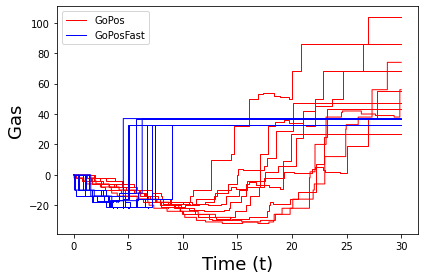

In [22]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

x,y = read_csv("gopos.csv")
x_fast, y_fast = read_csv("goposfast.csv")
plt.rcParams["figure.autolayout"] = True
for i in range(len(x)):
    if i == len(x)-1:
        plt.plot(x[i],y[i], c = "r", linewidth = 1, label = "GoPos")
    else:
        plt.plot(x[i],y[i], c = "r", linewidth = 1)
for i in range(len(x_fast)):
    if i == len(x_fast)-1:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1, label = "GoPosFast")
    else:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1)
plt.legend()
plt.savefig("simulation.png")
plt.xlabel("Time (t)",  fontsize=18)
plt.ylabel("Gas",  fontsize=18)
plt.show()